# Projeto 3 - Ciência dos Dados

#  Projeto UFC

Nome: Victor Vergara Arcoverde de Albuquerque Cavalcanti

Nome: Edgard Ortiz Neto

Nome: Gabriel Yamashita

Nome: Henrique Mualem Marti



  ___
## Objetivo:

### O objetivo desse projeto é fazer um machine learning para poder prever qual lutador ganhará uma luta do UFC baseado no seu histórico. Para isso serão usados os dados de todas as lutas do UFC (mais de 5 mil) a fim de descobrir quais os fatores dos lutadores que impactam mais no resultado das lutas. 
### Assim esse projeto poderia ser usado para apostadores nas lutas de UFC e os próprios atlétas que participam nessas lutas, pois seria possível comparar os seus dados e os de seus oponentes, assim sabendo como está em relação a eles e quais fatores seria melhor treinar ou manter a fim de manter uma vantagem sobre eles.

[Database utilizado](https://www.kaggle.com/rajeevw/ufcdata#data.csv)

____
## Método escolhido:






### Random Forest:
#### Esse método usa várias árvores de decisão para encontrar o que melhor se adequa, a que tem menos erros, para os nossos dados e o resultado que queremos, nesse caso quem é o vencedor.

![randomforest.png](randomforest.png)



### Regressão Logística:
#### Esse método usa a função abaixo que vai sempre tender a 0 ou a 1, assim sendo um classificador binário. Ele atribui um coeficiente(β) para cada fator levado em consideração, assim tendo uma ordem de impacto dos fatores no resultado final.

$$Prob(y = 1 | X = x) = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 x_1 + \beta_2 x_2\right)}}$$

 ___
## Preparando o ambiente no jupyter:


### Imports:

In [88]:
import math
import os.path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import random
import statsmodels.api as sm
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


### Trabalhando com os Excels:

In [89]:
data = pd.read_excel("data.xlsx")
data.head(2)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0


In [90]:
data.weight_class = data.weight_class.astype('category')
data.Winner = data.Winner.astype('category')

### Análise Exploratória

In [91]:
data.Winner.value_counts()

Red     3470
Blue    1591
Draw      83
Name: Winner, dtype: int64

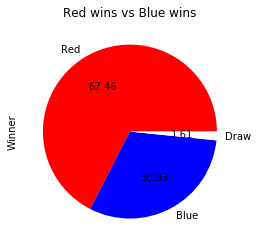

In [92]:
plt.title("Red wins vs Blue wins")
data.Winner.value_counts().plot(kind='pie', colors=['red','blue','white'], autopct="%0.2f",legend=False);

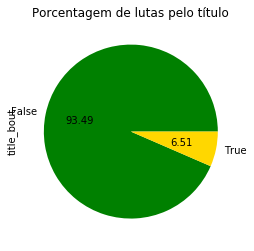

In [93]:
plt.title("Porcentagem de lutas pelo título")
data['title_bout'].value_counts().plot(kind='pie', colors=['green','gold'],autopct="%0.2f",legend=False);

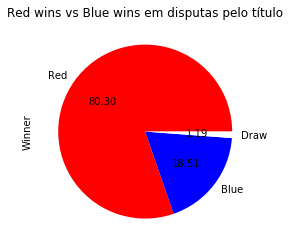

In [94]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==True),:]
plt.title("Red wins vs Blue wins em disputas pelo título")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False); 

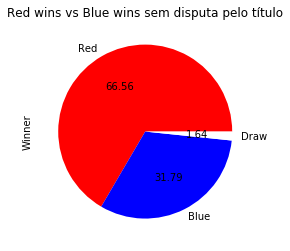

In [95]:
graf_winner_with_title = data.loc[: , ["Winner", "title_bout"]]
graf_winner_with_title1 = graf_winner_with_title.loc[(graf_winner_with_title.title_bout==False),:]
plt.title("Red wins vs Blue wins sem disputa pelo título")
graf_winner_with_title1.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False);

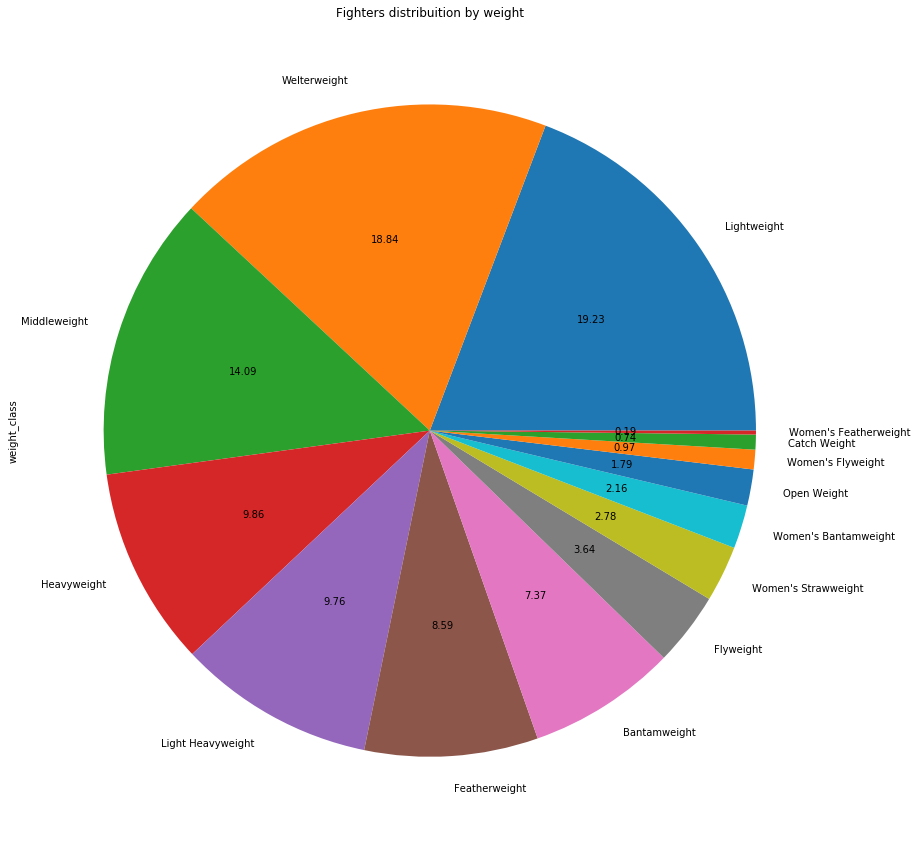

In [96]:
plt.figure(figsize=(20,15))
plt.title("Fighters distribuition by weight")
data['weight_class'].value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

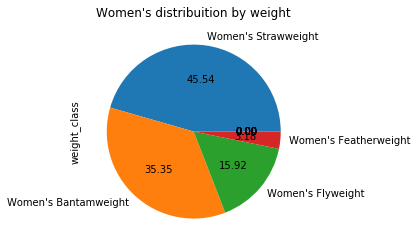

In [97]:
data_mulher = data.loc[(data.weight_class=="Women's Bantamweight")|
                       (data.weight_class=="Women's Featherweight")|
                       (data.weight_class=="Women's Flyweight")|
                       (data.weight_class=="Women's Strawweight"),:]
plt.title("Women's distribuition by weight")
data_mulher.weight_class.value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

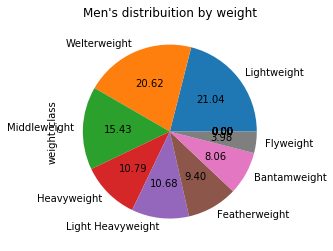

In [98]:
data_homem = data.loc[(data.weight_class=="Flyweight")|
                       (data.weight_class=="Bantamweight")|
                       (data.weight_class=="Featherweight")|
                       (data.weight_class=="Lightweight")|
                       (data.weight_class=="Welterweight")|
                       (data.weight_class=="Middleweight")|
                       (data.weight_class=="Light Heavyweight")|
                       (data.weight_class=="Heavyweight"),:]
plt.title("Men's distribuition by weight")
data_homem.weight_class.value_counts().plot(kind='pie',autopct="%0.2f",legend=False);

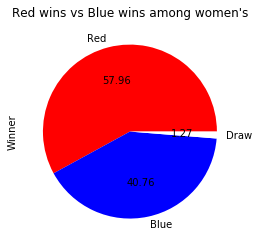

In [99]:
plt.title("Red wins vs Blue wins among women's")
data_mulher.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False);

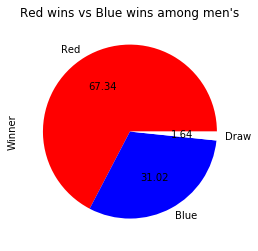

In [100]:
plt.title("Red wins vs Blue wins among men's")
data_homem.Winner.value_counts().plot(kind='pie', colors=['red','blue',"white"],autopct="%0.2f",legend=False);

In [101]:
#Escolhendo apenas as lutas entre lutadores da classe 'Heavyweight', pois as característica
#data_heavy = data.loc[(data.weight_class=='Heavyweight'),:]
bool_to_number = {False: 0, True: 1}
string_to_number = {'Blue': 0, 'Red': 1, 'Draw': 2}
data['title_bout'] = data['title_bout'].map(bool_to_number)
data['Winner'] = data['Winner'].map(string_to_number)
data.head(2)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019,"Chicago, Illinois, USA",1,1,Bantamweight,5,0,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019,"Chicago, Illinois, USA",1,1,Women's Flyweight,5,0,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0


#### Blue = 0
#### Red = 1

In [102]:
data_util = data.drop(['Referee','date','location'], axis=1)
#dados que não se relacionam com os lutadores ou seus resultado

In [103]:
data_util.head(2)

,R_fighter,B_fighter,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,1,1,Bantamweight,5,0,4,0,9.2,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,1,1,Women's Flyweight,5,0,3,0,14.6,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0


In [104]:
data_util.dropna(inplace=True)
data_util.head(2)

,R_fighter,B_fighter,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,...,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,1,1,Bantamweight,5,0,4,0,9.2,...,2,0,0,8,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,1,1,Women's Flyweight,5,0,3,0,14.6,...,0,2,0,5,Southpaw,165.10,167.64,125.0,32.0,31.0



### Tirando os dados categóricos:

In [105]:
categoricas = [
    'R_fighter', 
    'B_fighter', 
    'weight_class', 
    'R_Stance', 
    'B_Stance', 
]

data_cat = data_util[categoricas].astype('category')
data_num = data_util.drop(categoricas, axis=1).astype('float')

___
# Teste 1
___

In [106]:
X = data_num.drop('Winner', axis=1)
Y = data_num['Winner']


## Random Forest -1

### Separando os dados em testes e treinamento

In [107]:
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X, Y, test_size=0.25)

In [108]:
model_random = RandomForestClassifier(n_estimators=10000)

model_random.fit(X_train_random, y_train_random)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Verificando a performance 


In [111]:
y_pred_random = model_random.predict(X_test_random)

In [112]:
print(accuracy_score(y_test_random, y_pred_random))

0.6442786069651741


In [114]:
y_test_random.value_counts(True)

1.0    0.630597
0.0    0.354478
2.0    0.014925
Name: Winner, dtype: float64

In [115]:
data_num.Winner.value_counts()

1.0    2023
0.0    1141
2.0      51
Name: Winner, dtype: int64

## Regressão Logística -1

### Separando os dados em teste e treinamento

In [116]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, Y, test_size=0.25)

In [117]:
def preparo(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp,missing='drop')
    results = model.fit()
    return results

In [118]:
model = LogisticRegression(max_iter=200000,solver='lbfgs', multi_class='auto')

model.fit(X_train_log, y_train_log)

C:\Users\Maulem\Spyder\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


### Verificando a performance 


In [119]:
y_pred_log = model.predict(X_test_log)

In [120]:
print(accuracy_score(y_test_log, y_pred_log))

0.6691542288557214


In [122]:
y_test_random.value_counts(True)

1.0    0.630597
0.0    0.354478
2.0    0.014925
Name: Winner, dtype: float64

In [123]:
data_num.Winner.value_counts()

1.0    2023
0.0    1141
2.0      51
Name: Winner, dtype: int64

In [124]:
result = preparo(X_train_log,y_train_log)
result.summary()

C:\Users\Maulem\Spyder\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Winner   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     3.008
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           3.96e-23
Time:                        23:20:56   Log-Likelihood:                -1605.7
No. Observations:                2411   AIC:                             3449.
Df Residuals:                    2292   BIC:                             4138.
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.0246      0.449      4.511      0.000       1.145       2.905
title_bout                       0.1085      0.065      1.670      0.095      -0.019       0.236
no_of_rounds                    -0.0468      0.024     -1.963      0.050      -0.094   -3.74e-05
B_current_lose_streak           -0.0075      0.018     -0.425      0.671      -0.042       0.027
B_current_win_streak            -0.0148      0.011     -1.401      0.161      -0.036       0.006
B_draw                       -4.542e-15    9.3e-15     -0.488      0.625   -2.28e-14    1.37e-14
B_avg_BODY_att                   0.0089      0.005      1.655      0.098      -0.002       0.020
B_avg_BODY_landed               -0.0163      0.007     -2.241      0.025      -0.030      -0.002
B_avg_CLINCH_att                 0.0086      0.005      1.634      0.102      -0.002       0.019
B_avg_CLINCH_landed             -0.0134      0.007     -1.876      0.061      -0.027       0.001
B_avg_DISTANCE_att              -0.0017      0.003     -0.634      0.526      -0.007       0.004
B_avg_DISTANCE_landed            0.0003      0.004      0.085      0.932      -0.007       0.008
B_avg_GROUND_att                -0.0113      0.005     -2.401      0.016      -0.020      -0.002
B_avg_GROUND_landed              0.0169      0.007      2.477      0.013       0.004       0.030
B_avg_HEAD_att                   0.0048      0.003      1.444      0.149      -0.002       0.011
B_avg_HEAD_landed               -0.0089      0.005     -1.938      0.053      -0.018       0.000
B_avg_KD                        -0.0357      0.038     -0.944      0.345      -0.110       0.038
B_avg_LEG_att                   -0.0181      0.007     -2.532      0.011      -0.032      -0.004
B_avg_LEG_landed                 0.0290      0.009      3.182      0.001       0.011       0.047
B_avg_PASS                      -0.0075      0.011     -0.666      0.505      -0.029       0.014
B_avg_REV                        0.0123      0.040      0.306      0.760      -0.066       0.091
B_avg_SIG_STR_att               -0.0044      0.004     -1.043      0.297      -0.013       0.004
B_avg_SIG_STR_landed             0.0039      0.005      0.767      0.443      -0.006       0.014
B_avg_SIG_STR_pct               -0.0592      0.127     -0.467      0.640      -0.308       0.189
B_avg_SUB_ATT                    0.0152      0.019      0.796      0.426      -0.022       0.053
B_avg_TD_att                    -0.0215      0.008     -2.599      0.009      -0.038      -0.005
B_avg_TD_landed                 -0.0027      0.021     -0.131      0.896      -0.043       0.038
B_avg_TD_pct                    -0.0037      0.061     -0.061      0.951      -0.124       0.116
B_avg_TOTAL_STR_att             -0.0006      0.005     -0.111      0.912    

   ___
## Conclusão Teste 1 :

Tendo um acurácia média de 64% em ambos modelos não é um bom resultado, visto que o modelo praticamente sempre tem como resultado o vermelho como vencedor, e como a probabilidade do lutador vermelho ganhar é de 62.12112% ele praticamente só acerta os que o vencedor é o vermelho e erra os que o azul é o vencedor.

Assim é possível concluir que é necessário desconsiderar algumas variáveis para melhorar a acurácia.

   ___
## Criando um dataframe dos fatores mais impactantes no resultado segundo o Teste 1:

In [125]:
#Fatores que tem o maior peso na decisão da vitória
j=1
lista_j=list()
for i, f in sorted(list(zip(model_random.feature_importances_, X_train_random.columns)), reverse=True):
    a=str(j)+'°'
    lista_j.append(a)
    j+=1

In [126]:
data={'Fator':X_train_random.columns ,'Correlação':model_random.feature_importances_,}
Fator_por_corr=pd.DataFrame(data)
Fator_por_corr=Fator_por_corr.sort_values(by='Correlação', ascending=False)
Fator_por_corr['Grau de Importância']=lista_j
Fator_por_corr = Fator_por_corr.set_index('Grau de Importância')
Fator_por_corr.head(2)

,Fator,Correlação
Grau de Importância,,
1°,R_avg_opp_HEAD_landed,0.014745
2°,R_avg_opp_SIG_STR_landed,0.014574


In [ ]:
plt.title('Correlation between the columns and the Winner column')
plt.scatter(Fator_por_corr.index,Fator_por_corr.Correlação)

   ___
## Escolhendo quais dados devem ser usados nos modelos de predição:

In [127]:
def relevancia(df,coluna_nome,coluna_correlacao,acuracia):
    inuteis = []
    uteis = ['Winner']
    for index,row in df.iterrows():
        if row[coluna_correlacao] >= -acuracia and row[coluna_correlacao] <= acuracia:
            inuteis.append(row[coluna_nome])
        else:
            uteis.append(row[coluna_nome])
    return uteis

In [128]:
uteis = relevancia(Fator_por_corr,'Fator','Correlação',0.01)

In [129]:
data_util_relevante = data_util.loc[:,uteis]
data_util_relevante.head()

,Winner,R_avg_opp_HEAD_landed,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_age,R_avg_opp_DISTANCE_landed,R_avg_opp_TOTAL_STR_landed,B_age,R_avg_opp_BODY_att,R_avg_opp_TOTAL_STR_att,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_BODY_att,R_avg_TD_pct,R_avg_opp_BODY_landed
0,1,17.300000,32.200000,0.336000,32.0,26.800000,43.300000,31.0,13.300000,110.500000,65.40,22.600000,0.236000,9.200000,0.458000,8.800000
1,1,12.428571,44.714286,0.437143,31.0,32.571429,82.285714,32.0,24.571429,158.142857,138.90,51.300000,0.408000,14.600000,0.601429,14.142857
2,1,23.200000,35.733333,0.340000,35.0,32.200000,38.600000,36.0,14.466667,102.133333,97.00,46.774194,0.453226,15.354839,0.277333,8.133333
3,0,20.375000,44.875000,0.446250,29.0,38.500000,48.875000,26.0,20.250000,115.125000,136.25,70.250000,0.337500,17.000000,0.103750,13.375000
4,0,14.000000,22.500000,0.397500,26.0,16.250000,27.750000,32.0,6.250000,60.500000,203.50,61.500000,0.430000,17.000000,0.000000,4.750000


___
# Teste 2
____

In [130]:
x = data_util_relevante.drop('Winner', axis=1)
y = data_util_relevante['Winner']


## Random Forest -2

### Separando os dados em testes e treinamento

In [131]:
X_train_random2, X_test_random2, y_train_random2, y_test_random2 = train_test_split(x, y, test_size=0.25)

In [132]:
model_random2 = RandomForestClassifier(n_estimators=10000)

model_random2.fit(X_train_random2, y_train_random2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [134]:
model_random2.feature_importances_

array([0.06878305, 0.07114077, 0.07428007, 0.06097287, 0.06990811,
       0.06724793, 0.05576256, 0.06353908, 0.06665142, 0.0738484 ,
       0.06944276, 0.06902001, 0.06707201, 0.06235789, 0.05997307])

In [135]:
y_pred_random2 = model_random2.predict(X_test_random2)

In [136]:
print(accuracy_score(y_test_random2, y_pred_random2))

0.6368159203980099


In [138]:
y_test_random2.value_counts(True)

1    0.628109
0    0.360697
2    0.011194
Name: Winner, dtype: float64

In [139]:
data_util_relevante.Winner.value_counts()

1    2023
0    1141
2      51
Name: Winner, dtype: int64

___
## Montando a Regressão Logística -2



### Separando os dados em testes e treinamento

In [140]:
X_train_log2, X_test_log2, y_train_log2, y_test_log2 = train_test_split(X, Y, test_size=0.25)

In [141]:
model = LogisticRegression(max_iter=500000,solver='lbfgs', multi_class='auto')

model.fit(X_train_log2, y_train_log2)

C:\Users\Maulem\Spyder\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [142]:
y_pred_log2 = model.predict(X_test_log2)

In [143]:
print(accuracy_score(y_test_log2, y_pred_log2))

0.6256218905472637


In [145]:
y_test_log2.value_counts(True)

1.0    0.599502
0.0    0.383085
2.0    0.017413
Name: Winner, dtype: float64

In [146]:
data_util_relevante.Winner.value_counts()

1    2023
0    1141
2      51
Name: Winner, dtype: int64

In [147]:
def preparo(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp,missing='drop')
    results = model.fit()
    return results

In [148]:
result = preparo(x,y)
result.summary()

C:\Users\Maulem\Spyder\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Winner   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     13.41
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           1.80e-33
Time:                        23:22:43   Log-Likelihood:                -2272.4
No. Observations:                3215   AIC:                             4577.
Df Residuals:                    3199   BIC:                             4674.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.9397      0.107      8.770      0.000       0.730       1.150
R_avg_opp_HEAD_landed         -0.0015      0.003     -0.493      0.622      -0.007       0.004
R_avg_opp_SIG_STR_landed      -0.0031      0.004     -0.822      0.411      -0.010       0.004
R_avg_opp_SIG_STR_pct         -0.2319      0.113     -2.049      0.040      -0.454      -0.010
R_age                         -0.0168      0.002     -7.737      0.000      -0.021      -0.013
R_avg_opp_DISTANCE_landed      0.0003      0.002      0.119      0.905      -0.004       0.004
R_avg_opp_TOTAL_STR_landed     0.0002      0.001      0.163      0.871      -0.002       0.002
B_age                          0.0121      0.002      5.460      0.000       0.008       0.016
R_avg_opp_BODY_att             0.0018      0.006      0.290      0.772      -0.010       0.014
R_avg_opp_TOTAL_STR_att       -0.0002      0.001     -0.293      0.770      -0.002       0.001
B_avg_SIG_STR_att             -0.0007      0.001     -1.405      0.160      -0.002       0.000
B_avg_SIG_STR_landed           0.0005      0.001      0.411      0.681      -0.002       0.003
B_avg_opp_SIG_STR_pct          0.1883      0.078      2.409      0.016       0.035       0.342
B_avg_BODY_att                -0.0032      0.002     -1.726      0.084      -0.007       0.000
R_avg_TD_pct                   0.1142      0.041      2.816      0.005       0.035       0.194
R_avg_opp_BODY_landed          0.0027      0.009      0.307      0.759      -0.015       0.020
==============================================================================
Omnibus:                      236.821   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.369
Skew:                          -0.211   Prob(JB):                     2.64e-22
Kurtosis:                       2.249   Cond. No.                     2.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

___
## Conclusão Teste 2

Após a retirada dos dados considerados inúteis pelo primeiro modelo a acurácia de ambos modelos subiu um pouco, antes com uma média de 64% e agora com uma de 68%, ainda é considerada baixa levando em consideração a maioria das vitórias pelo lado vermelho (62.12112%). Se o modelo só tivesse como resultado vermelho a quantidade de acertos seria quase a mesma.

Para melhorar a acurâcia pode-se diminuir ainda mais o número de variáveis que o modelo usa ou até separar os dados por classe de Peso ou feminino e masculino.

## Teste 3

   ___
## Referências

[Como usar a biblioteca Scikit-lear](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

[Como funciona o Random Forest](https://towardsdatascience.com/understanding-random-forest-58381e0602d2)

[Referencia do Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[Como funciona regressão linear](https://www.saedsayad.com/logistic_regression.htm)

[Como usar a Regressão Linear](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)



In [ ]:
#criando um novo dataframe com apenas os lutadores sem repetição
def fighter_clean(data):
    newdata = pd.DataFrame()
    namelist = []

    for n in range(len(data.Fighter)):
        if data.loc[n,:]["Fighter"] not in namelist:
            namelist.append(data.loc[n,:]["Fighter"])
            newdata = pd.concat([newdata,data.loc[n,:]], axis=1, join='outer')

    newdata = newdata.transpose()
    return newdata


In [ ]:
#criando um novo dataframe
lista_locB = ["B_fighter", "weight_class","B_Height_cms","B_Reach_cms","B_Weight_lbs","B_age"]
lista_locR = ["R_fighter", "weight_class","R_Height_cms","R_Reach_cms","R_Weight_lbs","R_age"]
data_red = data.loc[: , lista_locR]
data_blue = data.loc[: , lista_locB]

data_blue.columns = ["Fighter","Weight_class","Height_cms","Reach_cms","Weight_lbs","Age"]
data_red.columns = ["Fighter","Weight_class","Height_cms","Reach_cms","Weight_lbs","Age"]

data_blue = fighter_clean(data_blue)
data_red = fighter_clean(data_red)

dataRB = pd.concat([data_red,data_blue], axis=0, join='outer')

dataRB.reset_index(inplace=True)
dataRB = fighter_clean(dataRB).loc[: , ["Age","Fighter","Height_cms","Reach_cms","Weight_class","Weight_lbs"]]

dataRB = dataRB.set_index("Fighter")

dataRB

In [ ]:
dataRB.loc["Henry Cejudo" , :]